In [1]:
import numpy as np
import pandas as pd

from collections import OrderedDict

from sklearn.model_selection import train_test_split

import readline 
import rpy2.rinterface
import rpy2.robjects as ro
from rpy2.robjects import pandas2ri
from rpy2.robjects.conversion import localconverter
pandas2ri.activate()

from CausalTree import *
%run ./datasets/simulate_treatment_data.py


%load_ext rpy2.ipython

In [2]:
%%R 
# read in necessary packages
pack <- c("tidyverse","plyr", "dplyr", "FNN", "modelr", "rpart", "doParallel", "grf")
#invisible(suppressMessages(suppressWarnings(lapply(pack, install.packages, character.only = TRUE))))
invisible(suppressMessages(suppressWarnings(lapply(pack, require, character.only = TRUE))))

# load relevant functions
#source("../Simulation_Study/helper_functions/rf_cate_JASA.R")
#source("../Simulation_Study/helper_functions/simAW.R")

In [4]:
%%R

simAW <- function (n, kC, d, add = FALSE) 
{
    D <- rbinom(n, size = 1, prob = 0.5)
    x <- matrix(runif(n * d), n, d)
    Int <- matrix(rep(0, n * d), n, d)
    for (j in seq_along(D)) {
        Int[j, ] <- D[j] * x[j, ]
    }
    eps0 <- rnorm(n, sd = 0)
    eps1 <- rnorm(n, sd = 0)
    tau <- function(x1, x2) {
        (1 + (1 + exp(-20 * (x1 - 1/3)))^(-1)) * (1 + (1 + exp(-20 * 
            (x2 - 1/3)))^(-1))
    }
    if (add) {
        betas0 <- matrix(runif(n = d, min = 1, max = 30), nrow = d, 
            ncol = 1)
        betas1 <- matrix(runif(n = d, min = 1, max = 30), nrow = d, 
            ncol = 1)
        y0 <- x %*% betas0 + eps0
        y1 <- x %*% betas1 + eps1
    }
    else {
        y0 <- -0.5 * (tau(x[, 1], x[, 2])) + eps0
        y1 <- 0.5 * (tau(x[, 1], x[, 2])) + eps1
    }
    Xs <- rep(0, d)
    nam <- rep(0, d)
    for (j in 1:d) {
        Xs[j] <- paste("res$X", j, sep = "")
        nam[j] <- paste("I", j, sep = "")
    }
    res <- data.frame(x)
    res <- as_tibble(res)
    Int_XD <- data.frame(Int)
    colnames(Int_XD) <- nam
    Int_XD <- as_tibble(Int_XD)
    res <- bind_cols(res, Int_XD)
    res <- add_column(res, D = D, Y0 = y0, Y1 = y1, Y_obs = rep(0, 
        n))
    res$Y_obs[res$D == 1] <- res$Y1[res$D == 1]
    res$Y_obs[res$D == 0] <- res$Y0[res$D == 0]
    allX <- grep("^[X]", names(res), value = TRUE)
    Tg <- res[res$D == 1, allX]
    Cg <- res[res$D == 0, allX]
    Tgy <- res$Y_obs[res$D == 1]
    Cgy <- res$Y_obs[res$D == 0]
    nnTg2 <- get.knnx(data = Tg, query = res[, allX], kC)
    treat <- apply(matrix(data = Tgy[nnTg2$nn.index], dim(nnTg2$nn.index)), 
        1, mean)
    nnCg2 <- get.knnx(data = Cg, query = res[, allX], kC)
    cont <- apply(matrix(data = Cgy[nnCg2$nn.index], dim(nnCg2$nn.index)), 
        1, mean)
    vhat <- (var(res$Y_obs[nnTg2$nn.index]) + var(res$Y_obs[nnCg2$nn.index]))/(kC * 
        (kC - 1))
    res <- add_column(res, tauhatknn = treat - cont)
    res <- add_column(res, vartauhatknn = vhat)
    allX <- grep("^[X]", names(res), value = TRUE)
    allDX <- grep("^[I]", names(res), value = TRUE, ignore.case = FALSE)
    all <- c(allX, allDX)
    fmla <- as.formula(paste("Y_obs ~ D + ", paste(all, collapse = "+")))
    reslm <- lm(fmla, data = res)
    coef <- matrix(reslm$coefficients[c(allDX, "D")], nrow = d + 
        1, ncol = 1)
    const <- matrix(rep(1, n), nrow = n, ncol = 1)
    X <- as.matrix(cbind(res[, c(allX)], const))
    C_ols <- as.vector(t(coef) %*% t(X))
    res <- add_column(res, Cate_ols = C_ols)
    if (add) {
        res <- add_column(res, CATE = x %*% (betas1 - betas0))
    }
    else {
        res <- add_column(res, CATE = tau(res$X1, res$X2))
    }
    return(res)
}

In [5]:
%%R
# set parameter values
n  <- 500 # number of observations
K  <- 6 # number of covariates 
kC <- 20 # number of nearest neighbors (for knn) 

# simulate data 
r_df <- simAW(n, kC, K)

train_ind  <- sample(seq_len(n), size = floor(.7 * n))
r_df_train <- r_df[train_ind, ]
r_df_test  <- r_df[-train_ind, ]

# compute cate using grf
allX <- grep("^[X]", names(r_df_train), value = TRUE)
cf <- grf::causal_forest(X = as.matrix(r_df_train[, allX]), 
                         Y = as.matrix(r_df_train$Y_obs),
                         W = as.matrix(r_df_train$D),
                         num.trees = 100,
                         num.threads = 1,
                         honesty = FALSE)
        
cf_pred <- predict(cf, as.matrix(r_df_test[, allX]))
cf_mse <- sum((r_df_test$CATE- cf_pred)^2) / nrow(r_df_test)

In [6]:
r_df_train = ro.r('r_df_train')
r_df_test = ro.r('r_df_test')
r_mse_grf = ro.r('cf_mse')
K = ro.r('K')
with localconverter(ro.default_converter + pandas2ri.converter):
    df_train = ro.conversion.rpy2py(r_df_train)
    df_test = ro.conversion.rpy2py(r_df_test)
    mse_grf = ro.conversion.rpy2py(r_mse_grf)
    K = int(ro.conversion.rpy2py(K))

df_train.head()

,X1,X2,X3,X4,X5,X6,I1,I2,I3,I4,I5,I6,D,Y0,Y1,Y_obs,tauhatknn,vartauhatknn,Cate_ols,CATE
1,0.755801,0.588492,0.424854,0.183878,0.519678,0.944099,0.755801,0.588492,0.424854,0.183878,0.519678,0.944099,1,-1.993746,1.993746,1.993746,3.653824,0.011371,3.527183,3.987492
2,0.167092,0.705610,0.085070,0.749102,0.037637,0.213383,0.167092,0.705610,0.085070,0.749102,0.037637,0.213383,1,-1.034427,1.034427,1.034427,2.677895,0.011371,2.544778,2.068854
3,0.941456,0.761083,0.507014,0.954846,0.463675,0.637947,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0,-1.999802,1.999802,-1.999802,3.918558,0.011371,4.276248,3.999604
4,0.594288,0.972808,0.390502,0.689053,0.289759,0.212197,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0,-1.994614,1.994614,-1.994614,3.730973,0.011371,4.063980,3.989228
5,0.161838,0.410847,0.636495,0.129201,0.715931,0.454337,0.161838,0.410847,0.636495,0.129201,0.715931,0.454337,1,-0.941105,0.941105,0.941105,2.170323,0.011371,1.949452,1.882210


In [7]:
X_test = df_test.iloc[:, 0:K].copy()

y_train = df_train['Y_obs'].copy()
X_train = df_train.iloc[:, 0:K].copy()
D_train = df_train['D'].copy()

In [10]:
ctree_sparse, ctree_opt = CausalTree.apply_kFold_CV(X_train, y_train, D_train, k = 5)

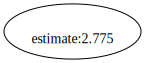

In [11]:
ctree_opt.plot()

In [12]:
tree_max = CausalTree()
tree_max.fit(X_train, y_train, D_train)

Causal Tree; fitted = True; id = 140208172240968

In [15]:
for i in [2]:
    tree_list = CausalTree.get_level_in_list(tree_max, i)
    for tree in tree_list:
        tree.left_child = None
        tree.right_child = None

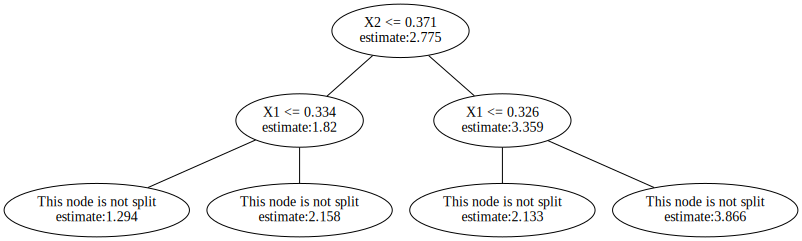

In [16]:
tree_max.plot()

In [24]:
tau_hat_causal_tree = tree_max.predict(X_test)
tau_hat_knn = df_test['tauhatknn'].values
tau_hat_ols = df_test['Cate_ols'].values
tau_real = df_test['CATE'].values

tau_hat_dict = OrderedDict()
tau_hat_dict["knn"] = tau_hat_knn
tau_hat_dict["ols"] = tau_hat_ols,
tau_hat_dict["ctree"] = tau_hat_causal_tree

mse_dict = OrderedDict()
mse_dict['grf'] = float(mse_grf)

for key, value in tau_hat_dict.items():
    mse_dict[key] = ((tau_real - value) ** 2).mean()

In [25]:
mse_dict

OrderedDict([('grf', 0.01874242926830955),
             ('knn', 0.24007334076297268),
             ('ols', 0.24838203978159962),
             ('ctree', 0.10081927681778602)])

In [19]:
X, y, D = simulate_treatment_data(agents=500, noise=True)

In [20]:
sparse, opt = CausalTree.apply_kFold_CV(X, y, D)

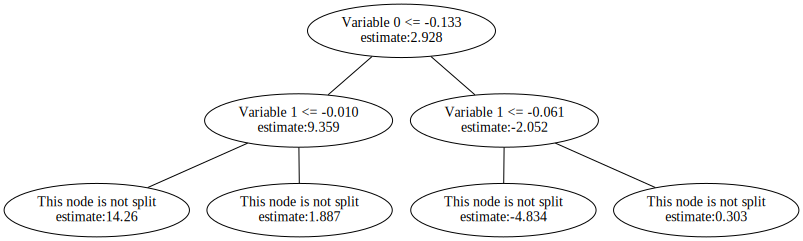

In [21]:
sparse.plot()